In [62]:
# Utility libraries
import  os
from    dotenv                 import load_dotenv
from    pathlib                import Path
import  calendar
from    datetime               import *
import  requests
from    dateutil.relativedelta import *

# APIs
from    fredapi                import Fred
import  yfinance               as     yf

# Modeling libraries
import  numpy                  as     np
import  pandas                 as     pd
from    fbprophet              import Prophet
from    MCForecastTools        import MCSimulation

# Visualisation libraries
import  seaborn                as     sns
import  holoviews              as     hv
import  hvplot.pandas
import  plotly.express         as     px
import  matplotlib.pyplot      as     plt

# Set ups
plt.style.use("fivethirtyeight")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
pd.set_option("max_columns", 500)

### Retrieving historical data for the chosen crypto currencies from `Yahoo Finance` using the open source `yfinance` API.  We will be examining the following currencies in particular:
* Bitcoin - `BTC-USD`
* Ethereum - `ETH-USD`
* Binance Coin - `BNB-USD`
* Dogecoin - `DOGE-USD`
* Monero - `XMR-USD`
* NEM - `XEM-USD`

In [63]:
data_df = yf.download(
    "BTC-USD, ETH-USD, BNB-USD, DOGE-USD, XMR-USD, XEM-USD", 
    period="max"
)

[*********************100%***********************]  6 of 6 completed


In [64]:
# Review data to see the date ranges
display(data_df.head())
display(data_df.tail())

Adj Close                                                Close  \
             BNB-USD     BTC-USD DOGE-USD ETH-USD XEM-USD XMR-USD BNB-USD   
Date                                                                        
2014-09-17       NaN  457.334015      NaN     NaN     NaN     NaN     NaN   
2014-09-18       NaN  424.440002      NaN     NaN     NaN     NaN     NaN   
2014-09-19       NaN  394.795990      NaN     NaN     NaN     NaN     NaN   
2014-09-20       NaN  408.903992      NaN     NaN     NaN     NaN     NaN   
2014-09-21       NaN  398.821014      NaN     NaN     NaN     NaN     NaN   

                                                           High              \
               BTC-USD DOGE-USD ETH-USD XEM-USD XMR-USD BNB-USD     BTC-USD   
Date                                                                          
2014-09-17  457.334015      NaN     NaN     NaN     NaN     NaN  468.174011   
2014-09-18  424.440002      NaN     NaN     NaN     NaN     NaN  456.859985   
2014-09-19  394.795990      NaN     NaN     NaN     NaN     NaN  427.834991   
2014-09-20  408.903992      NaN     NaN     NaN     NaN     NaN  423.295990   
2014-09-21  398.821014      NaN     NaN     NaN     NaN     NaN  412.425995   

                                                Low                       \
           DOGE-USD ETH-USD XEM-USD XMR-USD BNB-USD     BTC-USD DOGE-USD   
Date                                                                       
2014-09-17      NaN     NaN     NaN     NaN     NaN  452.421997      NaN   
2014-09-18      NaN     NaN     NaN     NaN     NaN  413.104004      NaN   
2014-09-19      NaN     NaN     NaN     NaN     NaN  384.532013      NaN   
2014-09-20      NaN     NaN     NaN     NaN     NaN  389.882996      NaN   
2014-09-21      NaN     NaN     NaN     NaN     NaN  393.181000      NaN   

                                      Open                               \
           ETH-USD XEM-USD XMR-USD BNB-USD     BTC-USD DOGE-USD ETH-USD   
Date                                                                      
2014-09-17     NaN     NaN     NaN     NaN  465.864014      NaN     NaN   
2014-09-18     NaN     NaN     NaN     NaN  456.859985      NaN     NaN   
2014-09-19     NaN     NaN     NaN     NaN  424.102997      NaN     NaN   
2014-09-20     NaN     NaN     NaN     NaN  394.673004      NaN     NaN   
2014-09-21     NaN     NaN     NaN     NaN  408.084991      NaN     NaN   

                            Volume                                             
           XEM-USD XMR-USD BNB-USD   BTC-USD DOGE-USD ETH-USD XEM-USD XMR-USD  
Date                                                                           
2014-09-17     NaN     NaN     NaN  21056800      NaN     NaN     NaN     NaN  
2014-09-18     NaN     NaN     NaN  34483200      NaN     NaN     NaN     NaN  
2014-09-19     NaN     NaN     NaN  37919700      NaN     NaN     NaN     NaN  
2014-09-20     NaN     NaN     NaN  36863600      NaN     NaN     NaN     NaN  
2014-09-21     NaN     NaN     NaN  26580100      NaN     NaN     NaN     NaN

Adj Close                                                 \
               BNB-USD       BTC-USD  DOGE-USD      ETH-USD   XEM-USD   
Date                                                                    
2022-10-30  313.754791  20635.603516  0.117802  1590.783325  0.039265   
2022-10-31  326.360718  20495.773438  0.127026  1572.714478  0.039009   
2022-11-01  324.579437  20485.273438  0.142575  1579.704590  0.039070   
2022-11-02  320.150543  20159.503906  0.127830  1519.711792  0.037760   
2022-11-03  324.379333  20351.939453  0.134318  1553.189209  0.038645   

                             Close                                       \
               XMR-USD     BNB-USD       BTC-USD  DOGE-USD      ETH-USD   
Date                                                                      
2022-10-30  147.528564  313.754791  20635.603516  0.117802  1590.783325   
2022-10-31  149.146301  326.360718  20495.773438  0.127026  1572.714478   
2022-11-01  149.668274  324.579437  20485.273438  0.142575  1579.704590   
2022-11-02  146.864075  320.150543  20159.503906  0.127830  1519.711792   
2022-11-03  149.216263  324.379333  20351.939453  0.134318  1553.189209   

                                        High                          \
             XEM-USD     XMR-USD     BNB-USD       BTC-USD  DOGE-USD   
Date                                                                   
2022-10-30  0.039265  147.528564  318.069275  20917.005859  0.141657   
2022-10-31  0.039009  149.146301  336.795319  20795.320312  0.130245   
2022-11-01  0.039070  149.668274  334.206238  20647.289062  0.157203   
2022-11-02  0.037760  146.864075  329.039459  20742.810547  0.147391   
2022-11-03  0.038645  149.216263  324.379333  20373.373047  0.135990   

                                                      Low                \
                ETH-USD   XEM-USD     XMR-USD     BNB-USD       BTC-USD   
Date                                                                      
2022-10-30  1637.037842  0.040500  150.294434  302.534363  20547.462891   
2022-10-31  1630.452881  0.039454  150.670090  307.625336  20287.458984   
2022-11-01  1606.605713  0.039705  151.028610  317.935516  20359.845703   
2022-11-02  1613.410645  0.039062  151.222656  316.280914  20087.134766   
2022-11-03  1555.804199  0.038765  149.433319  318.598877  20148.492188   

                                                               Open  \
            DOGE-USD      ETH-USD   XEM-USD     XMR-USD     BNB-USD   
Date                                                                  
2022-10-30  0.112892  1579.485229  0.039016  146.375259  304.229919   
2022-10-31  0.115076  1555.918945  0.038587  146.167877  313.671356   
2022-11-01  0.125177  1568.098511  0.039002  148.479172  326.277863   
2022-11-02  0.124067  1507.244751  0.037413  145.082825  324.467987   
2022-11-03  0.127069  1517.101685  0.037741  146.779877  319.927704   

                                                                       \
                 BTC-USD  DOGE-USD      ETH-USD   XEM-USD     XMR-USD   
Date                                                                    
2022-10-30  20817.982422  0.121644  1619.697876  0.039927  148.933197   
2022-10-31  20633.695312  0.117752  1590.481323  0.039266  147.539291   
2022-11-01  20494.898438  0.126985  1572.645386  0.039020  149.143295   
2022-11-02  20482.958984  0.142524  1579.497925  0.039062  149.664124   
2022-11-03  20158.783203  0.127291  1518.341675  0.037760  146.779877   

                  Volume                                                      \
                 BNB-USD      BTC-USD      DOGE-USD       ETH-USD    XEM-USD   
Date                                                                           
2022-10-30  1.451550e+09  31486345556  7.908594e+09  1.393007e+10  6412616.0   
2022-10-31  2.168406e+09  45668466815  5.814247e+09  1.930692e+10  6993634.0   
2022-11-01  1.329110e+09  39819303159  7.877293e+09  1.450731e+10  7193443.0   
2022-11-02  1.4

### Data review and clean up

In [65]:
#  Check how much data is available, data types and if there are null values in any of the columns
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2970 entries, 2014-09-17 to 2022-11-03
Freq: D
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (Adj Close, BNB-USD)   1821 non-null   float64
 1   (Adj Close, BTC-USD)   2970 non-null   float64
 2   (Adj Close, DOGE-USD)  1821 non-null   float64
 3   (Adj Close, ETH-USD)   1821 non-null   float64
 4   (Adj Close, XEM-USD)   1821 non-null   float64
 5   (Adj Close, XMR-USD)   1821 non-null   float64
 6   (Close, BNB-USD)       1821 non-null   float64
 7   (Close, BTC-USD)       2970 non-null   float64
 8   (Close, DOGE-USD)      1821 non-null   float64
 9   (Close, ETH-USD)       1821 non-null   float64
 10  (Close, XEM-USD)       1821 non-null   float64
 11  (Close, XMR-USD)       1821 non-null   float64
 12  (High, BNB-USD)        1821 non-null   float64
 13  (High, BTC-USD)        2970 non-null   float64
 14  (High, DOGE-USD)       1821 no

In [66]:
# Retain the key columns for each currency
data_df = data_df.drop(columns = ['Adj Close', 'High', 'Low', 'Open', 'Volume'])
data_df.columns = data_df.columns.droplevel()     # Changes the multilevel indexing on columns to single level
data_df.tail()

BNB-USD       BTC-USD  DOGE-USD      ETH-USD   XEM-USD  \
Date                                                                    
2022-10-30  313.754791  20635.603516  0.117802  1590.783325  0.039265   
2022-10-31  326.360718  20495.773438  0.127026  1572.714478  0.039009   
2022-11-01  324.579437  20485.273438  0.142575  1579.704590  0.039070   
2022-11-02  320.150543  20159.503906  0.127830  1519.711792  0.037760   
2022-11-03  324.379333  20351.939453  0.134318  1553.189209  0.038645   

               XMR-USD  
Date                    
2022-10-30  147.528564  
2022-10-31  149.146301  
2022-11-01  149.668274  
2022-11-02  146.864075  
2022-11-03  149.216263

In [67]:
# Drop all null values and sort index
data_df = data_df.dropna()
data_df.sort_index(inplace=True)

### Visualising the dataset

In [68]:
data_df.hvplot(
    x="Date", 
    y=list(data_df.columns),
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

### Reviewing each currency separately to see the trend

In [69]:
data_df.hvplot(
    x="Date", 
    y=list(data_df.columns),
    subplots=True,
    shared_axes=False
).cols(2)

:NdLayout   [Variable]
   :Curve   [Date]   (value)

#### The separate charts of each currency show that there is variability particularly from year 2021.  An examination of world events reveal that the global Covid pandemic was in full swing and a likely contributor to the volatility `[citation]`.

### We will now compare the crypto currencies' trends to available economic data
#### The economic data will be retrieved from the `Federal Reserve Bank of St Louis (FRED)` using its publicly available API.
#### Starting with equities `S&P 500`

In [70]:
# Set observation start date
start_date = data_df.index[0]

In [71]:
# Retrieve API keys to FRED (Federal Reserve Bank of St Louis)
load_dotenv()
fred_api_key = os.getenv("FRED_API_KEY")
if not(fred_api_key):
    print("Failed to load API credentials")

In [72]:
fred = Fred(api_key=fred_api_key)
sp500 = fred.get_series("SP500", observation_start=start_date)

In [73]:
display(sp500.head())
display(sp500.tail())

2017-11-09    2584.62
2017-11-10    2582.30
2017-11-13    2584.84
2017-11-14    2578.87
2017-11-15    2564.62
dtype: float64

2022-10-27    3807.30
2022-10-28    3901.06
2022-10-31    3871.98
2022-11-01    3856.10
2022-11-02    3759.69
dtype: float64

In [74]:
sp500 = sp500.dropna().copy()

In [75]:
(data_df.hvplot(label="Crypto Currencies") + sp500.hvplot(label="S&P 500"))

:Layout
   .NdOverlay.Crypto_Currencies :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Curve.S_ampersand_P_500     :Curve   [index]   (0)

#### Check correlation

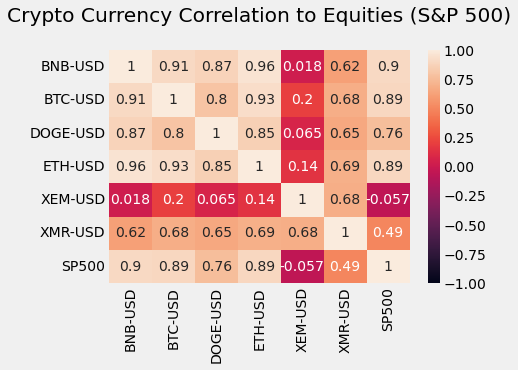

In [76]:
crypto_sp500_df = pd.concat([data_df, sp500], axis=1, join="inner")
crypto_sp500_df = crypto_sp500_df.rename(columns={0: "SP500"})
crypto_sp500_corr = crypto_sp500_df.corr()
ax = sns.heatmap(crypto_sp500_corr, vmin=-1, vmax=1, annot=True)
ax.set_title("Crypto Currency Correlation to Equities (S&P 500)\n")
plt.show()

#### There is a medium to strong correlation between the `S&P 500` and most of the currencies with the exception of `NEM`

### Comparing to `interest rate` trend

In [77]:
int_df = fred.get_series("DFF", observation_start=start_date)

In [78]:
display(int_df.head())
display(int_df.tail())

2017-11-09    1.16
2017-11-10    1.16
2017-11-11    1.16
2017-11-12    1.16
2017-11-13    1.16
dtype: float64

2022-10-28    3.08
2022-10-29    3.08
2022-10-30    3.08
2022-10-31    3.08
2022-11-01    3.08
dtype: float64

In [79]:
int_df.isna().sum()

0

In [80]:
(data_df.hvplot(label="Crypto Currencies") + int_df.hvplot(label="Interest Rates in US"))

:Layout
   .NdOverlay.Crypto_Currencies :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Curve.Interest_Rates_in_US  :Curve   [index]   (0)

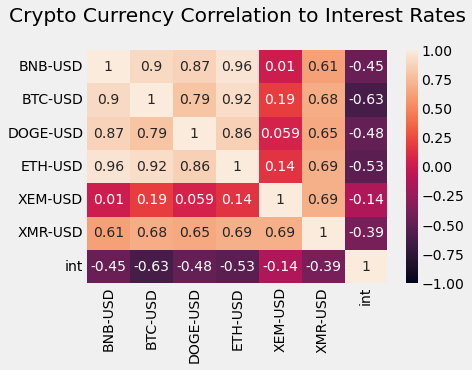

In [81]:
crypto_int_df = pd.concat([data_df, int_df], axis=1, join="inner")
crypto_int_df = crypto_int_df.rename(columns={0: "int"})
crypto_int_corr = crypto_int_df.corr()
ax = sns.heatmap(crypto_int_corr, vmin=-1, vmax=1, annot=True)
ax.set_title("Crypto Currency Correlation to Interest Rates\n")
plt.show()

#### There is a moderately negative correlation between the currencies and the `US interest rates`.

### Compare to `GDP`

In [82]:
gdp_df = fred.get_series("GDPC1", observation_start=start_date)

In [83]:
display(gdp_df.head())
display(gdp_df.tail())

2017-10-01    18310.300
2018-01-01    18437.127
2018-04-01    18565.697
2018-07-01    18699.748
2018-10-01    18733.741
dtype: float64

2021-07-01    19672.594
2021-10-01    20006.181
2022-01-01    19924.088
2022-04-01    19895.271
2022-07-01    20021.721
dtype: float64

In [84]:
gdp_df.isna().sum()

0

In [85]:
(data_df.hvplot(label="Crypto Currencies") + gdp_df.hvplot(label="GDP in US"))

:Layout
   .NdOverlay.Crypto_Currencies :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Curve.GDP_in_US             :Curve   [index]   (0)

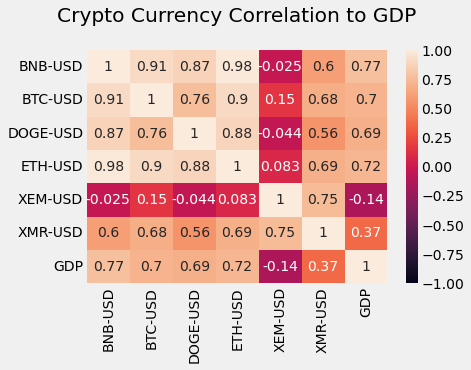

In [86]:
crypto_gdp_df = pd.concat([data_df, gdp_df], axis=1, join="inner")
crypto_gdp_df = crypto_gdp_df.rename(columns={0: "GDP"})
crypto_gdp_corr = crypto_gdp_df.corr()
ax = sns.heatmap(crypto_gdp_corr, vmin=-1, vmax=1, annot=True)
ax.set_title("Crypto Currency Correlation to GDP\n")
plt.show()

#### There is moderate to strong relationship between `GDP` and the currencies suggesting that they move up and down with the equities market.

### Checking `CPI`

In [87]:
cpi_df = fred.get_series("CPIAUCSL", observation_start=start_date)

In [88]:
display(cpi_df.head())
display(cpi_df.tail())

2017-11-01    247.284
2017-12-01    247.805
2018-01-01    248.743
2018-02-01    249.439
2018-03-01    249.581
dtype: float64

2022-05-01    291.474
2022-06-01    295.328
2022-07-01    295.271
2022-08-01    295.620
2022-09-01    296.761
dtype: float64

In [89]:
cpi_df.isna().sum()

0

In [90]:
(data_df.hvplot(label="Crypto Currencies") + cpi_df.hvplot(label="CPI in US"))

:Layout
   .NdOverlay.Crypto_Currencies :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Curve.CPI_in_US             :Curve   [index]   (0)

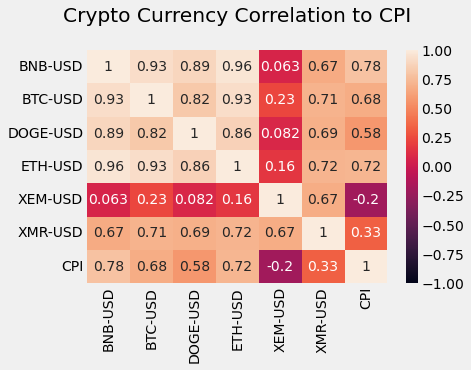

In [91]:
crypto_cpi_df = pd.concat([data_df, cpi_df], axis=1, join="inner")
crypto_cpi_df = crypto_cpi_df.rename(columns={0: "CPI"})
crypto_cpi_corr = crypto_cpi_df.corr()
ax = sns.heatmap(crypto_cpi_corr, vmin=-1, vmax=1, annot=True)
ax.set_title("Crypto Currency Correlation to CPI\n")
plt.show()

#### Changes in `CPI` is also likely to have an impact in the value of the chosen currencies.

#### Checking agains the price of `gold`

In [92]:
gold_df = yf.download(
    "GOLD", 
    start=start_date
)

[*********************100%***********************]  1 of 1 completed


In [93]:
display(gold_df.head())
display(gold_df.tail())

Open   High    Low  Close  Adj Close    Volume
Date                                                       
2017-11-09  14.06  14.13  13.95  14.11  12.729628   8248600
2017-11-10  14.10  14.14  13.90  13.98  12.612346   7187400
2017-11-13  13.97  14.02  13.93  13.95  12.585279   7348400
2017-11-14  13.84  14.07  13.84  14.01  12.639409   7613800
2017-11-15  14.10  14.18  13.91  13.95  12.585279  10758100

Open   High    Low  Close  Adj Close    Volume
Date                                                       
2022-10-27  15.67  15.77  15.45  15.48      15.48  17918300
2022-10-28  15.32  15.44  15.19  15.31      15.31  16819400
2022-10-31  15.14  15.28  15.02  15.03      15.03  17850000
2022-11-01  15.40  15.50  15.10  15.14      15.14  24127000
2022-11-02  15.20  15.31  14.28  14.34      14.34  33408200

In [94]:
gold_df = gold_df.drop(columns=["Open", "High", "Low", "Close", "Volume"])
gold_df.head()

Adj Close
Date                 
2017-11-09  12.729628
2017-11-10  12.612346
2017-11-13  12.585279
2017-11-14  12.639409
2017-11-15  12.585279

In [95]:
gold_df.isna().sum()

Adj Close    0
dtype: int64

In [96]:
(data_df.hvplot(label="Crypto Currencies") + gold_df.hvplot(label="Gold"))

:Layout
   .NdOverlay.Crypto_Currencies :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Curve.Gold                  :Curve   [Date]   (Adj Close)

In [97]:
crypto_gold_df = pd.concat([data_df, gold_df], axis=1, join="inner")
crypto_gold_df = crypto_gold_df.rename(columns={0: "GOLD"})
crypto_gold_corr = crypto_gold_df.corr()
crypto_gold_corr

BNB-USD   BTC-USD  DOGE-USD   ETH-USD   XEM-USD   XMR-USD  \
BNB-USD    1.000000  0.905908  0.868622  0.956809  0.017845  0.616747   
BTC-USD    0.905908  1.000000  0.795399  0.925416  0.196471  0.679967   
DOGE-USD   0.868622  0.795399  1.000000  0.854597  0.064843  0.653946   
ETH-USD    0.956809  0.925416  0.854597  1.000000  0.144839  0.694310   
XEM-USD    0.017845  0.196471  0.064843  0.144839  1.000000  0.682558   
XMR-USD    0.616747  0.679967  0.653946  0.694310  0.682558  1.000000   
Adj Close  0.329990  0.422040  0.310650  0.319480 -0.136774  0.080349   

           Adj Close  
BNB-USD     0.329990  
BTC-USD     0.422040  
DOGE-USD    0.310650  
ETH-USD     0.319480  
XEM-USD    -0.136774  
XMR-USD     0.080349  
Adj Close   1.000000

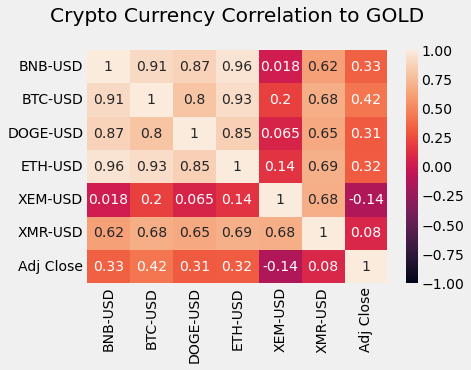

In [98]:
ax = sns.heatmap(crypto_gold_corr, vmin=-1, vmax=1, annot=True)
ax.set_title("Crypto Currency Correlation to GOLD\n")
plt.show()

#### The price of `gold` appears to only moderately affect crypto currency values.

#### Checking against the price of crude oil

In [99]:
crude_df = yf.download(
    "CL=F", 
    start=start_date
)

[*********************100%***********************]  1 of 1 completed


In [100]:
display(crude_df.head())
display(crude_df.tail())

Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2017-11-09  56.849998  57.529999  56.689999  57.169998  57.169998  666949
2017-11-10  57.020000  57.349998  56.549999  56.740002  56.740002  541296
2017-11-13  56.900002  57.150002  56.299999  56.759998  56.759998  631619
2017-11-14  56.720001  56.770000  54.810001  55.700001  55.700001  707338
2017-11-15  55.060001  55.560001  54.880001  55.330002  55.330002  501385

Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2022-10-28  88.669998  88.760002  87.080002  87.900002  87.900002  263404
2022-10-31  88.389999  88.650002  85.300003  86.529999  86.529999  285342
2022-11-01  86.430000  89.449997  85.919998  88.370003  88.370003  274321
2022-11-02  88.620003  90.360001  87.720001  90.000000  90.000000  274321
2022-11-03  89.349998  89.669998  88.800003  89.430000  89.430000   12210

In [101]:
crude_df = crude_df.drop(columns=["Open", "High", "Low", "Close", "Volume"])
crude_df.head()

Adj Close
Date                 
2017-11-09  57.169998
2017-11-10  56.740002
2017-11-13  56.759998
2017-11-14  55.700001
2017-11-15  55.330002

In [102]:
crude_df.isna().sum()

Adj Close    0
dtype: int64

In [103]:
(data_df.hvplot(label="Crypto Currencies") + crude_df.hvplot(label="Crude Oil"))

:Layout
   .NdOverlay.Crypto_Currencies :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Curve.Crude_Oil             :Curve   [Date]   (Adj Close)

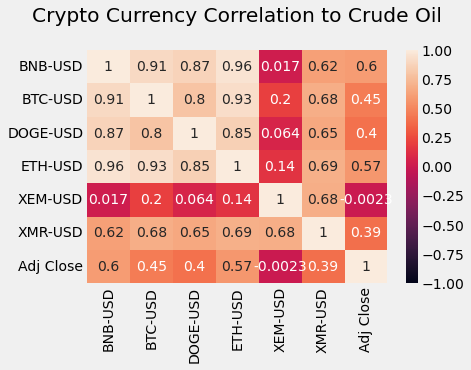

In [104]:
crypto_crude_df = pd.concat([data_df, crude_df], axis=1, join="inner")
crypto_crude_df = crypto_crude_df.rename(columns={0: "Crude"})
crypto_crude_corr = crypto_crude_df.corr()
ax = sns.heatmap(crypto_crude_corr, vmin=-1, vmax=1, annot=True)
ax.set_title("Crypto Currency Correlation to Crude Oil\n")
plt.show()

#### The price of `crude oil` seems to have a moderate impact on the value of the chosen currencies.

### Reviewing the gains / losses of rhe chosen currencies.

In [105]:
# Calculate % change
daily_change = data_df.pct_change()
daily_change.head()

BNB-USD   BTC-USD  DOGE-USD   ETH-USD   XEM-USD   XMR-USD
Date                                                                  
2017-11-09       NaN       NaN       NaN       NaN       NaN       NaN
2017-11-10 -0.097415 -0.073554 -0.178092 -0.067411 -0.126847 -0.125799
2017-11-11 -0.070329 -0.039368  0.032674  0.051555 -0.002462  0.132877
2017-11-12 -0.090262 -0.064101 -0.135720 -0.021523 -0.062475  0.035447
2017-11-13  0.109845  0.102422  0.166667  0.028606  0.067936 -0.003666

In [106]:
# Drop the null first row from the `daily_change` data set
daily_change = daily_change.dropna()
daily_change.head()

BNB-USD   BTC-USD  DOGE-USD   ETH-USD   XEM-USD   XMR-USD
Date                                                                  
2017-11-10 -0.097415 -0.073554 -0.178092 -0.067411 -0.126847 -0.125799
2017-11-11 -0.070329 -0.039368  0.032674  0.051555 -0.002462  0.132877
2017-11-12 -0.090262 -0.064101 -0.135720 -0.021523 -0.062475  0.035447
2017-11-13  0.109845  0.102422  0.166667  0.028606  0.067936 -0.003666
2017-11-14 -0.055757  0.011626 -0.022296  0.066037  0.009379 -0.008501

In [107]:
daily_change.describe()

BNB-USD      BTC-USD     DOGE-USD      ETH-USD      XEM-USD  \
count  1820.000000  1820.000000  1820.000000  1820.000000  1820.000000   
mean      0.004575     0.001389     0.006200     0.002176     0.001427   
std       0.061012     0.040125     0.112615     0.050750     0.074988   
min      -0.419046    -0.371695    -0.402570    -0.423472    -0.344734   
25%      -0.022159    -0.015964    -0.023954    -0.021897    -0.029242   
50%       0.001065     0.001273    -0.000758     0.000990     0.000630   
75%       0.028326     0.018223     0.020390     0.027802     0.027801   
max       0.697604     0.252472     3.555466     0.264581     1.706284   

           XMR-USD  
count  1820.000000  
mean      0.001636  
std       0.054689  
min      -0.413860  
25%      -0.024236  
50%       0.001964  
75%       0.029346  
max       0.411925

In [108]:
average = daily_change.mean()
average = average.sort_values()
average

BTC-USD     0.001389
XEM-USD     0.001427
XMR-USD     0.001636
ETH-USD     0.002176
BNB-USD     0.004575
DOGE-USD    0.006200
dtype: float64

In [109]:
std = daily_change.std()
std = std.sort_values()
std

BTC-USD     0.040125
ETH-USD     0.050750
XMR-USD     0.054689
BNB-USD     0.061012
XEM-USD     0.074988
DOGE-USD    0.112615
dtype: float64

In [110]:
# Calculate cumulative returns of all portfolios
cumulative_returns = (1 + daily_change).cumprod()
cumulative_returns.head()

BNB-USD   BTC-USD  DOGE-USD   ETH-USD   XEM-USD   XMR-USD
Date                                                                  
2017-11-10  0.902585  0.926446  0.821908  0.932589  0.873153  0.874201
2017-11-11  0.839107  0.889974  0.848763  0.980669  0.871003  0.990363
2017-11-12  0.763368  0.832925  0.733569  0.959562  0.816586  1.025468
2017-11-13  0.847220  0.918236  0.855830  0.987011  0.872062  1.021709
2017-11-14  0.799982  0.928911  0.836749  1.052190  0.880241  1.013024

In [111]:
# Plot cumulative returns
cummulative_returns = cumulative_returns.dropna()

In [112]:
cummulative_returns.hvplot()

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

#### The above chart show that investors in `DOGE` coins would have experienced the most volatility and potentially greater rewards than investors in the remaining currencies.

### Plot the price change charts as sub-plots

In [113]:
# Drop the daily_change `Close` column index level
daily_change_by_crypto = daily_change.copy()
daily_change_by_crypto.head()

BNB-USD   BTC-USD  DOGE-USD   ETH-USD   XEM-USD   XMR-USD
Date                                                                  
2017-11-10 -0.097415 -0.073554 -0.178092 -0.067411 -0.126847 -0.125799
2017-11-11 -0.070329 -0.039368  0.032674  0.051555 -0.002462  0.132877
2017-11-12 -0.090262 -0.064101 -0.135720 -0.021523 -0.062475  0.035447
2017-11-13  0.109845  0.102422  0.166667  0.028606  0.067936 -0.003666
2017-11-14 -0.055757  0.011626 -0.022296  0.066037  0.009379 -0.008501

### Visual inspection the spread of the variability in each currency

In [114]:
daily_change_columns = daily_change_by_crypto.columns
daily_change_by_crypto.hvplot(
    x="Date", 
    y=["BTC-USD", "ETH-USD", "BNB-USD", "DOGE-USD", "XMR-USD", "XEM-USD"], 
    subplots=True
).cols(2)

:NdLayout   [Variable]
   :Curve   [Date]   (value)

#### The individual charts above show that a significant event in the first quarter of 2020 caused prices to drop across the board.  `Binance` and `DOGE` has signiificant gains in early 2021 with `DOGE` investors earning the most returns. `[citation]`

### Review the distribution of returns

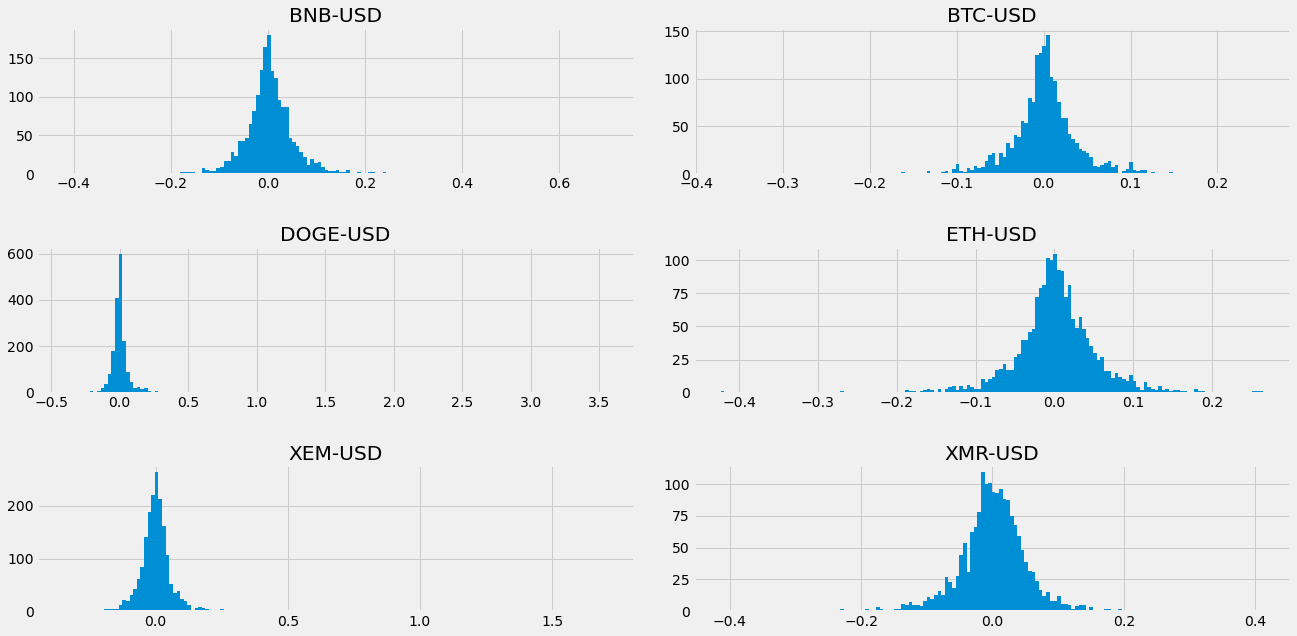

In [115]:
fig, axs = plt.subplots(3, 2, figsize=(20, 10),gridspec_kw={"hspace": 0.5, "wspace": 0.1})
axs = axs.flatten()
i = 0
for crypto in daily_change_by_crypto.columns:
    daily_change_by_crypto[crypto].hist(ax=axs[i], bins=150)
    axs[i].set_title(crypto)
    i += 1

### It is clear that the variability in some currencies is more spread from some than for others with `ETH` and `BTC` having the most spread.

### Checking for outliers

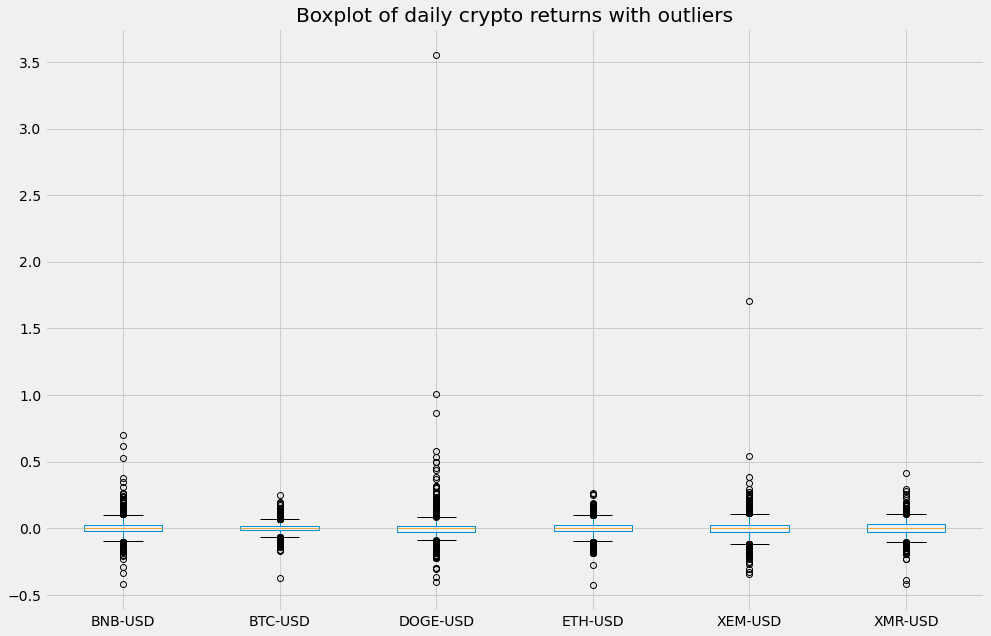

In [116]:
daily_change_by_crypto.boxplot(figsize=(15,10))
plt.title("Boxplot of daily crypto returns with outliers")
plt.show()

### `DOGE` is the most volatile currency with a significant tail.

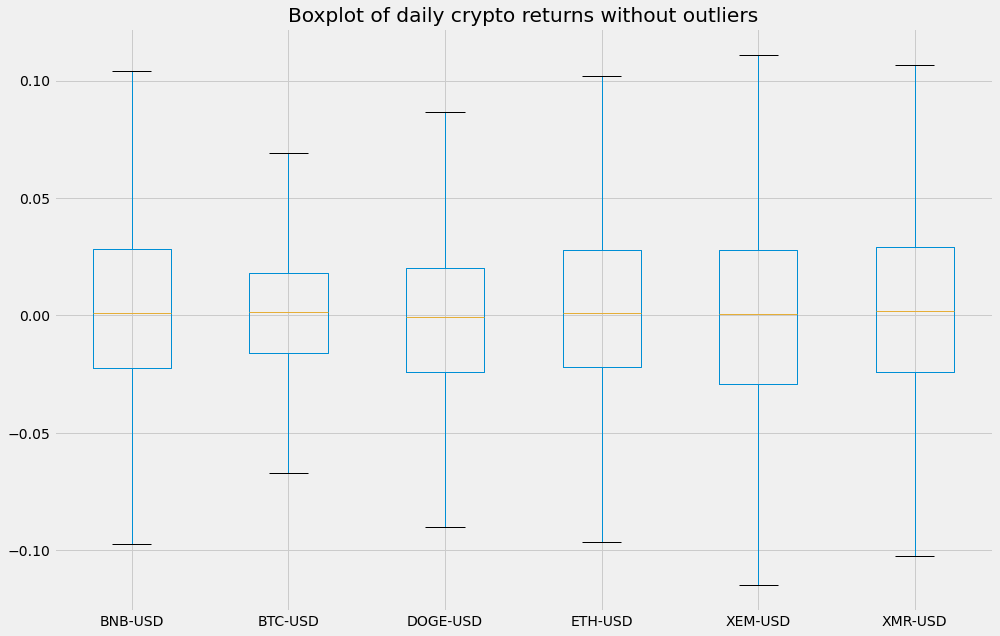

In [184]:
daily_change_by_crypto.boxplot(showfliers=False, figsize=(15,10))
plt.title("Boxplot of daily crypto returns without outliers")
plt.show()

In [118]:
# Calculate the correlation
correlation = daily_change.corr()
correlation

BNB-USD   BTC-USD  DOGE-USD   ETH-USD   XEM-USD   XMR-USD
BNB-USD   1.000000  0.626824  0.255925  0.614586  0.435754  0.572918
BTC-USD   0.626824  1.000000  0.357306  0.768160  0.457671  0.702409
DOGE-USD  0.255925  0.357306  1.000000  0.326850  0.236494  0.319933
ETH-USD   0.614586  0.768160  0.326850  1.000000  0.544807  0.702230
XEM-USD   0.435754  0.457671  0.236494  0.544807  1.000000  0.468923
XMR-USD   0.572918  0.702409  0.319933  0.702230  0.468923  1.000000

<AxesSubplot:>

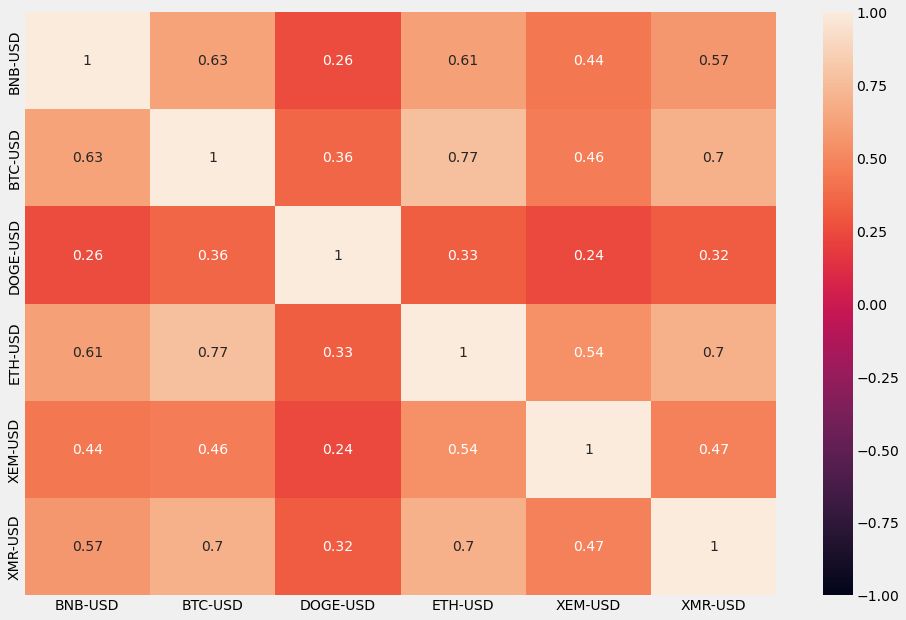

In [119]:
# Display correlation matrix
plt.figure(figsize = (15,10))
sns.heatmap(correlation, vmin=-1, vmax=1, annot=True)

## Forecast Analysis
### We will use facebook's prophet library to forecast directly from the timeseries for each crypto currency for the next 2 months

### We will now split the data into a training dataframe and a testing dataframe that can be using during the forecasting stage
#### Note that given the high degree of volatility associated with crypto currencies, the forecasting will be restricted to a maximum of 2 months

In [120]:
# Get today's date
cut_off_date = date.today()

# Let's make it two months ago 
cut_off_date  = pd.to_datetime(cut_off_date + relativedelta(months = -2))
display(cut_off_date)
training_df = data_df.loc[data_df.index < cut_off_date]
testing_df = data_df.loc[data_df.index >= cut_off_date]

Timestamp('2022-09-03 00:00:00')

In [121]:
# Visualise the two data sets
# training_df.hvplot().opts(title="Training Data") * testing_df.hvplot().opts(title="Testing Data")
training_test_ax = (training_df.hvplot() * testing_df.hvplot()).opts(title="Training / Test Data Set")
training_test_ax * hv.VLine(cut_off_date)

:Overlay
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .VLine.I      :VLine   [x,y]

In [122]:
# Take a copy of the original dataframe and reset index to convert the date index into a column
training_df = training_df.reset_index()
training_df.tail()

Date     BNB-USD       BTC-USD  DOGE-USD      ETH-USD   XEM-USD  \
1754 2022-08-29  286.221405  20297.994141  0.063887  1553.037354  0.044642   
1755 2022-08-30  281.425354  19796.808594  0.061525  1523.838867  0.043401   
1756 2022-08-31  279.238098  20049.763672  0.061330  1553.684937  0.044097   
1757 2022-09-01  278.417236  20127.140625  0.062372  1586.176758  0.044004   
1758 2022-09-02  277.416107  19969.771484  0.061635  1577.220459  0.043944   

         XMR-USD  
1754  152.634659  
1755  148.695724  
1756  149.027832  
1757  153.876877  
1758  153.444534

In [123]:
model_df = pd.DataFrame()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -37.0604
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3293.12     0.0793458       240.526           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3343.82    0.00931013       218.546       0.885       0.885      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     276       3367.18   0.000730168       243.347   6.589e-06       0.001      362  LS failed, Hessian reset 
     299       3373.38     0.0226622       149.916           1           1      386   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     382       3387.61   0.000234176       118.835   1.753e-06       0.001      545  LS failed, Hessian reset 
     399       3391.21     0.0829139       200.616           1           1      569   
    Iter      log pro

/home/gadam/anaconda3/envs/dev/lib/python3.7/site-packages/fbprophet/plot.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -53.2132
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3356.29    0.00475822       422.971      0.8163      0.8163      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3408.98    0.00458872       107.071           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3473.33     0.0081618       132.044           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3498.76     0.0362991       685.971           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3506.64    0.00587943       400.629      0.4254      0.4254      592   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/gadam/anaconda3/envs/dev/lib/python3.7/site-packages/fbprophet/plot.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -19.391
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3927.03     0.0160653       592.542           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3984.16      0.039682       635.939           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4031.05        0.0306       229.573           1           1      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4077.94     0.0130161          1120      0.3008           1      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4102.48     0.0109527       211.327           1           1      600   
    Iter      log prob        ||dx||      ||grad||       alpha   

/home/gadam/anaconda3/envs/dev/lib/python3.7/site-packages/fbprophet/plot.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -41.7036
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3475.09     0.0961669       2263.46      0.6176      0.6176      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3586.9      0.012863       392.672           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        3635.8     0.0149875       376.244           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3672.18     0.0211558       592.604           1           1      481   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     414       3674.75     0.0012673       128.641   1.746e-05       0.001      549  LS failed, Hessian reset 
     422       3675.08   0.000120718    

/home/gadam/anaconda3/envs/dev/lib/python3.7/site-packages/fbprophet/plot.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -12.5071
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3819.64    0.00100741       159.497      0.1938      0.1938      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3839.8     0.0645953        787.98           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3846.74   0.000645553       96.2991       0.861       0.861      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     382       3854.42   0.000353314       234.654   1.096e-06       0.001      497  LS failed, Hessian reset 
     399       3855.11    0.00203726       150.832           1           1      517   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     457       3855.53   0.000240499    

/home/gadam/anaconda3/envs/dev/lib/python3.7/site-packages/fbprophet/plot.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -32.2493
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3442.97    0.00845833       219.498           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130        3449.6   0.000158952       66.2413   1.133e-06       0.001      195  LS failed, Hessian reset 
     146        3453.5   0.000188768       97.9587   1.363e-06       0.001      257  LS failed, Hessian reset 
     199       3460.57    0.00277204       113.757           1           1      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3466.65    0.00409615       207.786           1           1      444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     356       3471.97    0.00063449        131.69   9.693e-07       0.001      553  LS failed, Hessian rese

/home/gadam/anaconda3/envs/dev/lib/python3.7/site-packages/fbprophet/plot.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


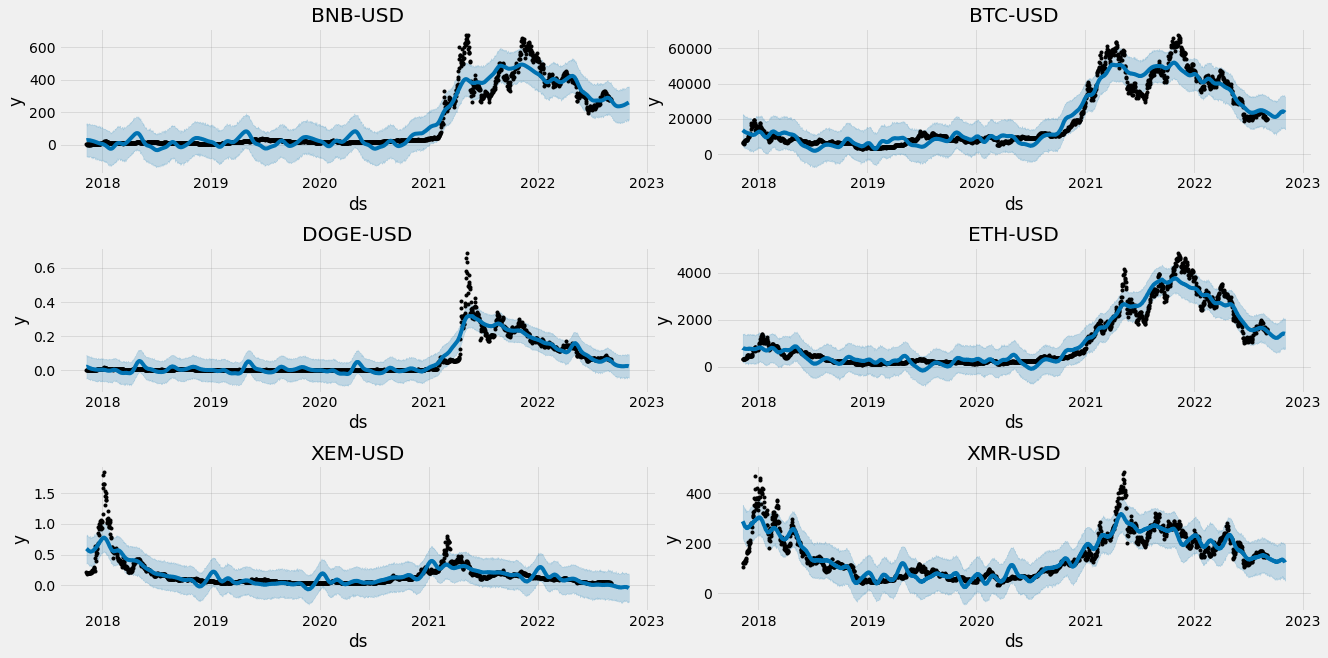

In [124]:
forecasts = {}
fig, axs = plt.subplots(3, 2, figsize=(20, 10),gridspec_kw={"hspace": 0.5, "wspace": 0.1})
axs = axs.flatten()
i = 0
for crypto in training_df.columns:
    if crypto == "Date":
        continue
    model_df[["ds", "y"]] = training_df[["Date", crypto]]
    # Initialise the model with 95% confidence interval
    model = Prophet(interval_width=0.95)
    # Train the model
    model.fit(model_df)
    # Create a future forecast
    future_df = model.make_future_dataframe(periods=60, freq="D")
    # Predict the future closing price
    forecast_df = model.predict(future_df)
    # Add the plot to the subplot set
    model.plot(forecast_df, ax=axs[i])
    axs[i].set_title(crypto)
    axs[i].xlabel="Year"
    # Save the forecast in the `forecasts` dictionary
    forecasts[crypto] = forecast_df
    del model
    i += 1

### Plot the original dataframe for comparison

In [125]:
training_df.hvplot(
    x="Date", 
    y=["BNB-USD", "BTC-USD", "DOGE-USD", "ETH-USD", "XEM-USD", "XMR-USD"], 
    subplots=True,
    shared_axes=False
).cols(2)

:NdLayout   [Variable]
   :Curve   [Date]   (value)

### Compare the forecast to the actual test data for the period predicted

In [126]:
# Split the forecast data into its own dataframe for the prediction period
predictions = {crypto:forecast_df.loc[forecast_df["ds"] >= cut_off_date] for (crypto, forecast_df) in forecasts.items()}

In [127]:
for (crypto, forecast_df) in predictions.items():
    forecast_df.hvplot(
        x="ds",
        xlabel="Date",
        y="yhat",
        ylabel="Price"
    ).opts(
        title=crypto
    )
    plt.show()

In [128]:
btc_predictions_ax = predictions["BTC-USD"].hvplot(
    x="ds",
    xlabel="Date",
    y="yhat",
    ylabel="Price",
    label="Forecast"
)
btc_testing_ax = testing_df.hvplot(
    x="Date",
    y="BTC-USD",
    label="Actual"
)

In [129]:
eth_predictions_ax = predictions["ETH-USD"].hvplot(
    x="ds",
    xlabel="Date",
    y="yhat",
    ylabel="Price",
    label="Forecast"
)
eth_testing_ax = testing_df.hvplot(
    x="Date",
    y="ETH-USD",
    label="Actual"
)

In [130]:
doge_predictions_ax = predictions["DOGE-USD"].hvplot(
    x="ds",
    xlabel="Date",
    y="yhat",
    ylabel="Price",
    label="Forecast"
)
doge_testing_ax = testing_df.hvplot(
    x="Date",
    y="DOGE-USD",
    label="Actual"
)

In [131]:
bnb_predictions_ax = predictions["BNB-USD"].hvplot(
    x="ds",
    xlabel="Date",
    y="yhat",
    ylabel="Price",
    label="Forecast"
)
bnb_testing_ax = testing_df.hvplot(
    x="Date",
    y="BNB-USD",
    label="Actual"
)

In [132]:
xem_predictions_ax = predictions["XEM-USD"].hvplot(
    x="ds",
    xlabel="Date",
    y="yhat",
    ylabel="Price",
    label="Forecast"
)
xem_testing_ax = testing_df.hvplot(
    x="Date",
    y="XEM-USD",
    label="Actual"
)

In [133]:
xmr_predictions_ax = predictions["XMR-USD"].hvplot(
    x="ds",
    xlabel="Date",
    y="yhat",
    ylabel="Price",
    label="Forecast"
)
xmr_testing_ax = testing_df.hvplot(
    x="Date",
    y="XMR-USD",
    label="Actual"
)

In [134]:
(btc_predictions_ax * btc_testing_ax).opts(title="BTC", legend_position="top_left")

:Overlay
   .Curve.Forecast :Curve   [ds]   (yhat)
   .Curve.Actual   :Curve   [Date]   (BTC-USD)

In [135]:
(eth_predictions_ax * eth_testing_ax).opts(title="ETH", legend_position="top_right")

:Overlay
   .Curve.Forecast :Curve   [ds]   (yhat)
   .Curve.Actual   :Curve   [Date]   (ETH-USD)

In [136]:
(doge_predictions_ax * doge_testing_ax).opts(title="DOGE", legend_position="top_left")

:Overlay
   .Curve.Forecast :Curve   [ds]   (yhat)
   .Curve.Actual   :Curve   [Date]   (DOGE-USD)

In [137]:
(bnb_predictions_ax * bnb_testing_ax).opts(title="BNB", legend_position="top_left")

:Overlay
   .Curve.Forecast :Curve   [ds]   (yhat)
   .Curve.Actual   :Curve   [Date]   (BNB-USD)

In [138]:
(xem_predictions_ax * xem_testing_ax).opts(title="XEM", legend_position="bottom_left")

:Overlay
   .Curve.Forecast :Curve   [ds]   (yhat)
   .Curve.Actual   :Curve   [Date]   (XEM-USD)

In [139]:
(xmr_predictions_ax * xmr_testing_ax).opts(title="XMR", legend_position="bottom_left")

:Overlay
   .Curve.Forecast :Curve   [ds]   (yhat)
   .Curve.Actual   :Curve   [Date]   (XMR-USD)

### Get economic data

### Get unemployment data

In [140]:
# Seasonally adjusted
unemployment_df = fred.get_series("UNRATE", observation_start=start_date)

In [141]:
display(unemployment_df.head())
display(unemployment_df.tail())

2017-11-01    4.2
2017-12-01    4.1
2018-01-01    4.0
2018-02-01    4.1
2018-03-01    4.0
dtype: float64

2022-05-01    3.6
2022-06-01    3.6
2022-07-01    3.5
2022-08-01    3.7
2022-09-01    3.5
dtype: float64

In [142]:
unemployment_df.isna().sum()

0

<AxesSubplot:title={'center':'US Unemployment Rate'}>

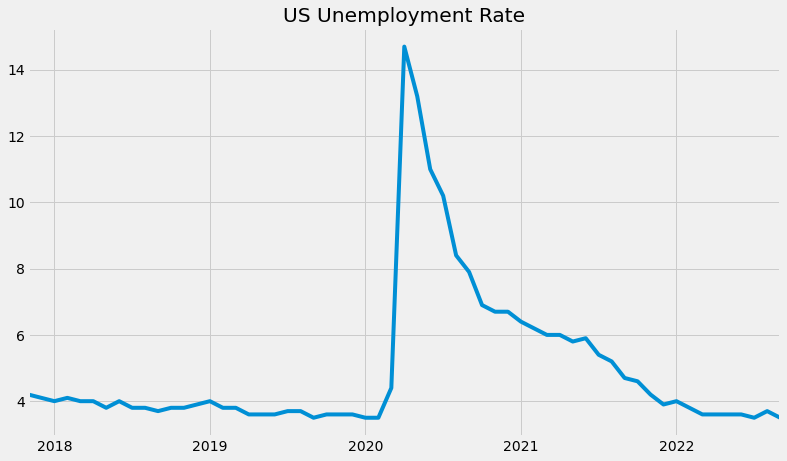

In [143]:
unemployment_df.plot(figsize=(12, 7), title="US Unemployment Rate")

### Search for CPI data

### Get GDP

### US Interest rates

<AxesSubplot:title={'center':'US Federal Reserve Effective Rate'}>

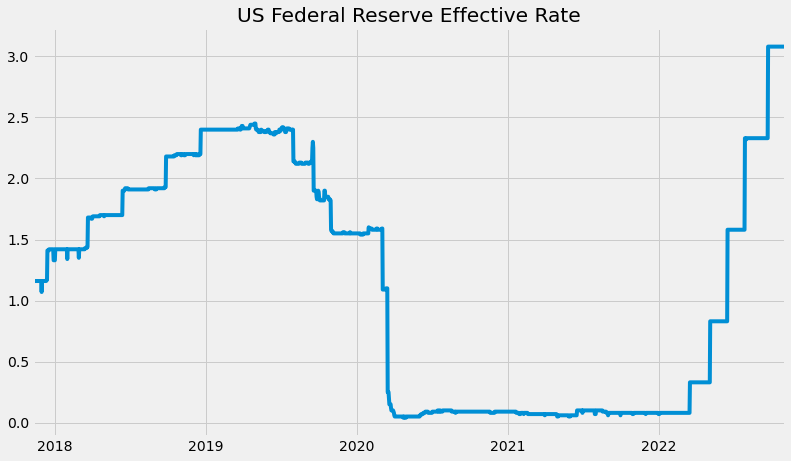

In [144]:
int_df.plot(figsize=(12, 7), title="US Federal Reserve Effective Rate")

### Unemployment benefit claims

In [145]:
unemployment_claims_df = fred.get_series("ICSA", observation_start=start_date)

In [146]:
display(unemployment_claims_df.head())
display(unemployment_claims_df.tail())

2017-11-11    254000.0
2017-11-18    246000.0
2017-11-25    243000.0
2017-12-02    241000.0
2017-12-09    229000.0
dtype: float64

2022-09-24    190000.0
2022-10-01    219000.0
2022-10-08    226000.0
2022-10-15    214000.0
2022-10-22    217000.0
dtype: float64

In [147]:
unemployment_claims_df.isna().sum()

0

<AxesSubplot:title={'center':'US Weekly Unemployment Insurance Claims'}>

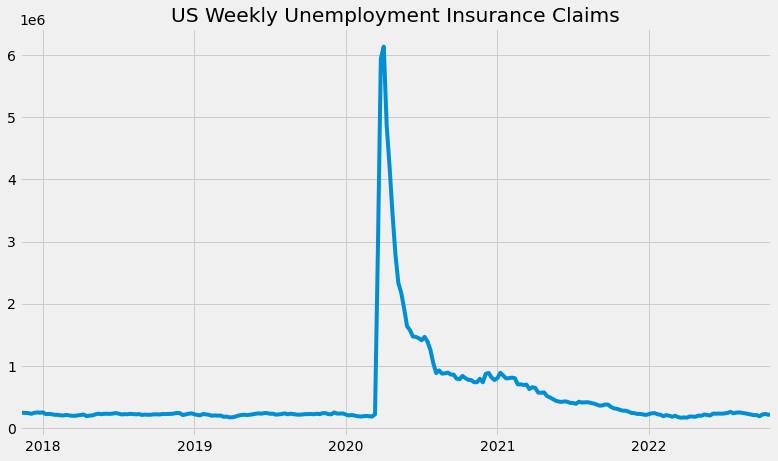

In [148]:
unemployment_claims_df.plot(figsize=(12, 7), title="US Weekly Unemployment Insurance Claims")

### Get labour force participation

In [149]:
labour_df = fred.get_series("CIVPART", observation_start=start_date)

In [150]:
display(labour_df.head())
display(labour_df.tail())

2017-11-01    62.7
2017-12-01    62.7
2018-01-01    62.7
2018-02-01    63.0
2018-03-01    62.9
dtype: float64

2022-05-01    62.3
2022-06-01    62.2
2022-07-01    62.1
2022-08-01    62.4
2022-09-01    62.3
dtype: float64

In [151]:
labour_df.isna().sum()

0

<AxesSubplot:title={'center':'US Labour Force Participation'}>

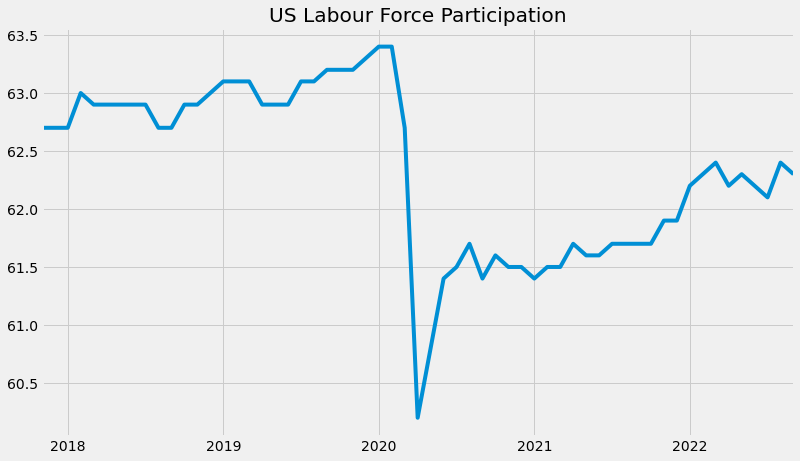

In [152]:
labour_df.plot(figsize=(12, 7), title="US Labour Force Participation")

### Collect economic data into merged visualisation

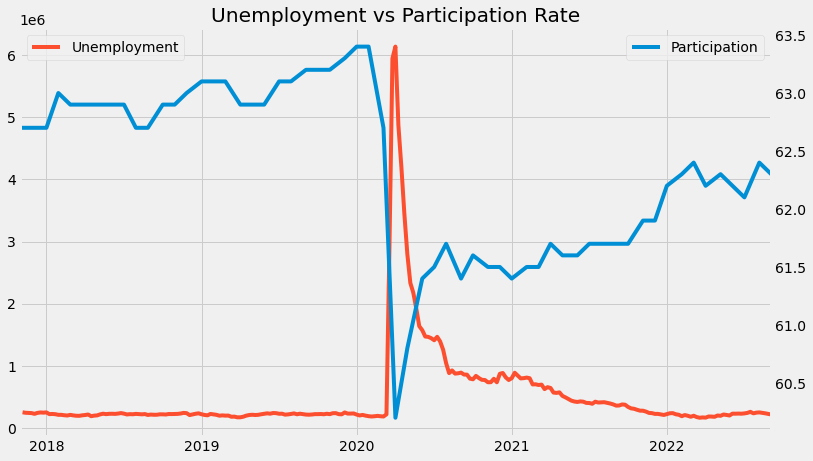

In [153]:
fig, ax = plt.subplots(figsize=(12, 7))
ax2 = ax.twinx()
unemployment_claims_df.plot(ax=ax, label="Unemployment", color=color_pal[1])
labour_df.plot(ax=ax2, label="Participation", color=color_pal[0])
ax2.grid(False)
ax.set_title("Unemployment vs Participation Rate")
ax.legend(loc="upper left")
ax2.legend()

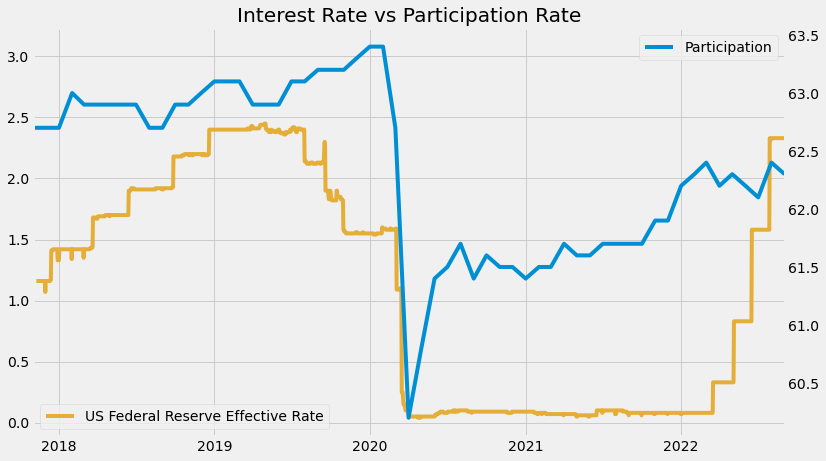

In [154]:
fig, ax = plt.subplots(figsize=(12, 7))
ax2 = ax.twinx()
int_df.plot(ax=ax, label="US Federal Reserve Effective Rate", color=color_pal[2])
labour_df.plot(ax=ax2, label="Participation", color=color_pal[0])
ax2.grid(False)
ax.set_title("Interest Rate vs Participation Rate")
ax.legend(loc="lower left")
ax2.legend()

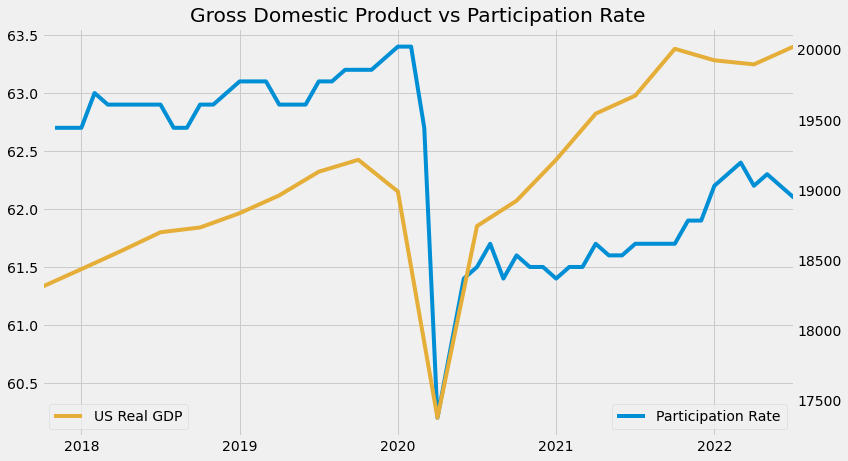

In [155]:
fig, ax = plt.subplots(figsize=(12, 7))
ax2 = ax.twinx()
labour_df.plot(ax=ax, label="Participation Rate", color=color_pal[0])
gdp_df.plot(ax=ax2, label="US Real GDP", color=color_pal[2])
ax2.grid(False)
ax.set_title("Gross Domestic Product vs Participation Rate")
ax.legend(loc="lower right")
ax2.legend(loc="lower left")

### Get the global price of energy

In [156]:
energy_df = fred.get_series("PNRGINDEXM", observation_start=start_date)
display(energy_df.head())
display(energy_df.tail())

2017-11-01    140.765423
2017-12-01    143.637979
2018-01-01    152.812740
2018-02-01    147.221808
2018-03-01    147.282110
dtype: float64

2022-04-01    300.533178
2022-05-01    306.674979
2022-06-01    328.123480
2022-07-01    343.809997
2022-08-01    376.412083
dtype: float64

In [157]:
energy_df.isna().sum()

0

<AxesSubplot:title={'center':'Global Energy Prices'}, ylabel='Index'>

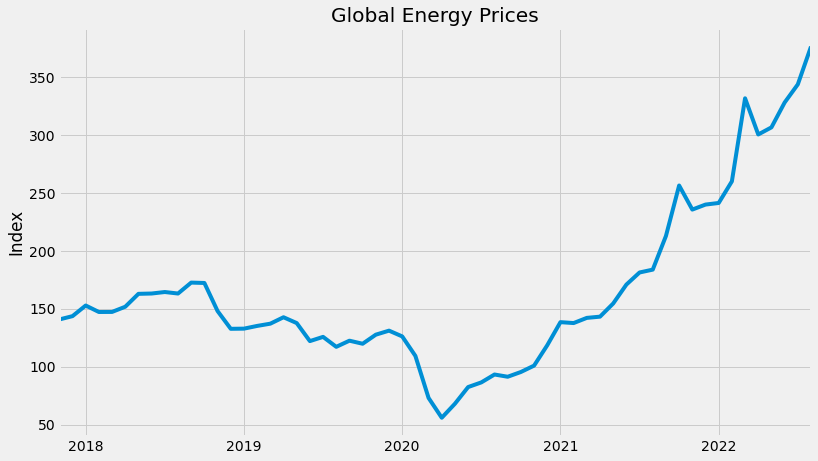

In [158]:
energy_df.plot(
    figsize=(12, 7), 
    title="Global Energy Prices",
    ylabel="Index"
)

### Looking at the economic uncertainty index of the *United States*

In [159]:
us_econ_df = fred.get_series("PNRGINDEXM", observation_start=start_date)
display(us_econ_df.head())
display(us_econ_df.tail())

2017-11-01    140.765423
2017-12-01    143.637979
2018-01-01    152.812740
2018-02-01    147.221808
2018-03-01    147.282110
dtype: float64

2022-04-01    300.533178
2022-05-01    306.674979
2022-06-01    328.123480
2022-07-01    343.809997
2022-08-01    376.412083
dtype: float64

In [160]:
us_econ_df.isna().sum()

0

Text(-80, -20, 'Source: Baker, Scott R., Bloom, Nick and Davis, Stephen J., Economic Policy Uncertainty Index for United States [USEPUINDXD], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/USEPUINDXD, October 28, 2022.')

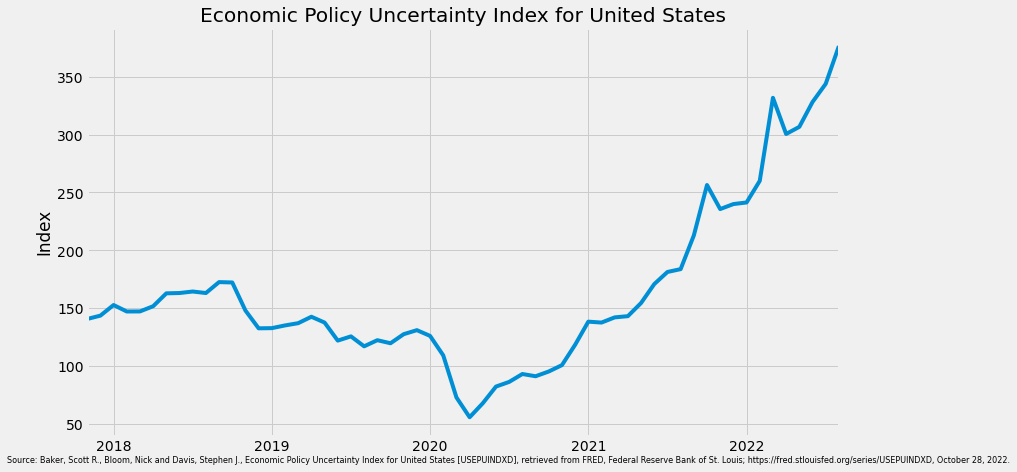

In [161]:
annotation = "Source: Baker, Scott R., Bloom, Nick and Davis, Stephen J., Economic Policy Uncertainty Index for United States [USEPUINDXD], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/USEPUINDXD, October 28, 2022."
plt_us_econ = us_econ_df.plot(
    figsize=(12, 7), 
    title="Economic Policy Uncertainty Index for United States",
    ylabel="Index"
)
plt_us_econ.annotate(annotation, (0,0), (-80,-20), fontsize=8, xycoords="axes fraction", textcoords="offset points", va="top")

### World uncertainty index for United States

In [162]:
us_uncertainty_df = fred.get_series("WUIUSA", observation_start=start_date)
display(us_uncertainty_df.head())
display(us_uncertainty_df.tail())

2017-10-01    0.157150
2018-01-01    0.000000
2018-04-01    0.210544
2018-07-01    0.307740
2018-10-01    0.250831
dtype: float64

2021-07-01    0.154528
2021-10-01    0.120839
2022-01-01    0.199144
2022-04-01    0.170571
2022-07-01    0.170629
dtype: float64

In [163]:
us_uncertainty_df.isna().sum()

0

Text(-80, -20, 'Source: Ahir, Hites, Bloom, Nick and Furceri, Davide, World Uncertainty Index for United States [WUIUSA], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/WUIUSA, October 28, 2022.')

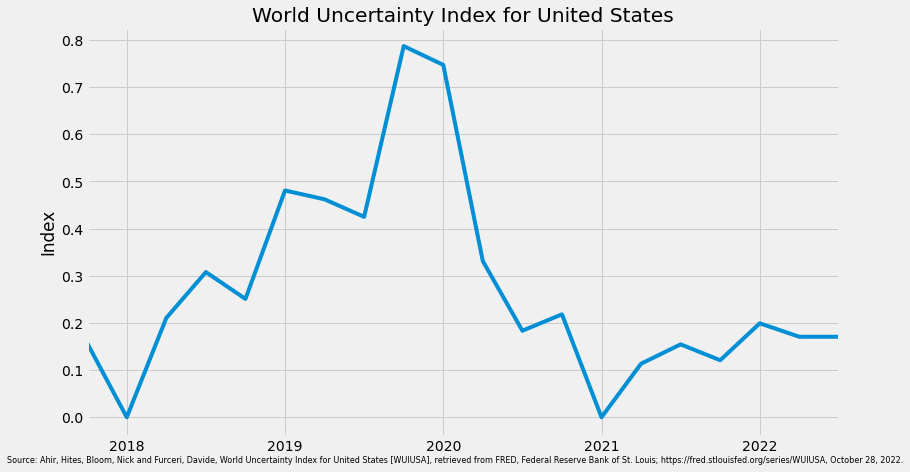

In [164]:
annotation = "Source: Ahir, Hites, Bloom, Nick and Furceri, Davide, World Uncertainty Index for United States [WUIUSA], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/WUIUSA, October 28, 2022."
plt_us_uncertainty = us_uncertainty_df.plot(
    figsize=(12, 7), 
    title="World Uncertainty Index for United States",
    ylabel="Index"
)
plt_us_uncertainty.annotate(annotation, (0,0), (-80,-20), fontsize=8, xycoords="axes fraction", textcoords="offset points", va="top")

### Comparing the policy uncertainty and world uncertainty indices for the United States

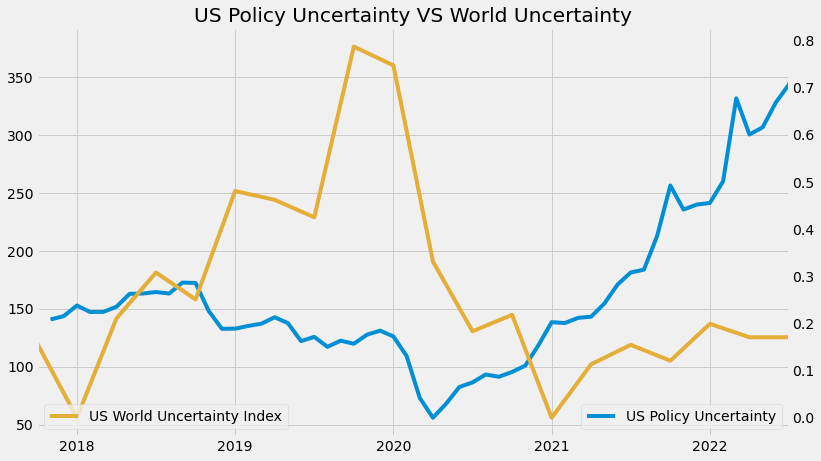

In [165]:
fig, ax = plt.subplots(figsize=(12, 7))
ax2 = ax.twinx()
us_econ_df.plot(ax=ax, label="US Policy Uncertainty", color=color_pal[0])
us_uncertainty_df.plot(ax=ax2, label="US World Uncertainty Index", color=color_pal[2])
ax2.grid(False)
ax.set_title("US Policy Uncertainty VS World Uncertainty")
ax.legend(loc="lower right")
ax2.legend(loc="lower left")

### European economic uncertainty

In [166]:
eu_econ_df = fred.get_series("EUEPUINDXM", observation_start=start_date)
display(eu_econ_df.head())
display(eu_econ_df.tail())

2017-11-01    229.71336
2017-12-01    173.39307
2018-01-01    196.43605
2018-02-01    135.16371
2018-03-01    175.57617
dtype: float64

2022-06-01    332.62823
2022-07-01    403.90579
2022-08-01    327.91541
2022-09-01    397.31982
2022-10-01    390.17599
dtype: float64

In [167]:
eu_econ_df.isna().sum()

0

Text(-80, -20, 'Source: Baker, Scott R., Bloom, Nick and Davis, Stephen J., Economic Policy Uncertainty Index for Europe [EUEPUINDXM], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/EUEPUINDXM, October 28, 2022.')

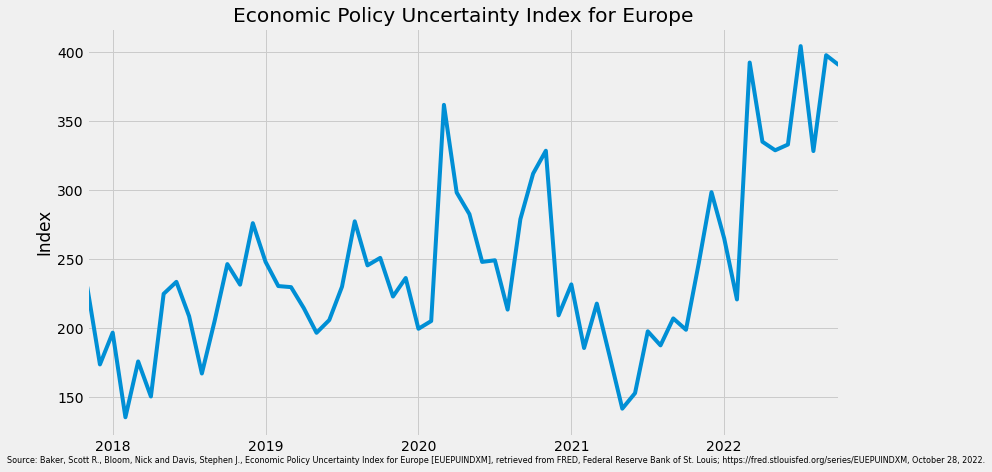

In [168]:
annotation = "Source: Baker, Scott R., Bloom, Nick and Davis, Stephen J., Economic Policy Uncertainty Index for Europe [EUEPUINDXM], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/EUEPUINDXM, October 28, 2022."
plt_eu_econ = eu_econ_df.plot(
    figsize=(12, 7), 
    title="Economic Policy Uncertainty Index for Europe",
    ylabel="Index"
)
plt_eu_econ.annotate(annotation, (0,0), (-80,-20), fontsize=8, xycoords="axes fraction", textcoords="offset points", va="top")

### Economic policy uncertainty index for China

In [169]:
ch_econ_df = fred.get_series("CHIEPUINDXM", observation_start=start_date)
display(ch_econ_df.head())
display(ch_econ_df.tail())

2017-11-01    268.04385
2017-12-01    269.35477
2018-01-01    122.93740
2018-02-01    211.78018
2018-03-01    245.55171
dtype: float64

2018-12-01    935.31030
2019-01-01    654.96265
2019-02-01    720.15790
2019-03-01    753.10773
2019-04-01    502.55005
dtype: float64

In [170]:
ch_econ_df.isna().sum()

0

Text(-80, -20, 'Source: Baker, Scott R., Bloom, Nick and Davis, Stephen J., Economic Policy Uncertainty Index for China [CHIEPUINDXM], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CHIEPUINDXM, October 28, 2022.')

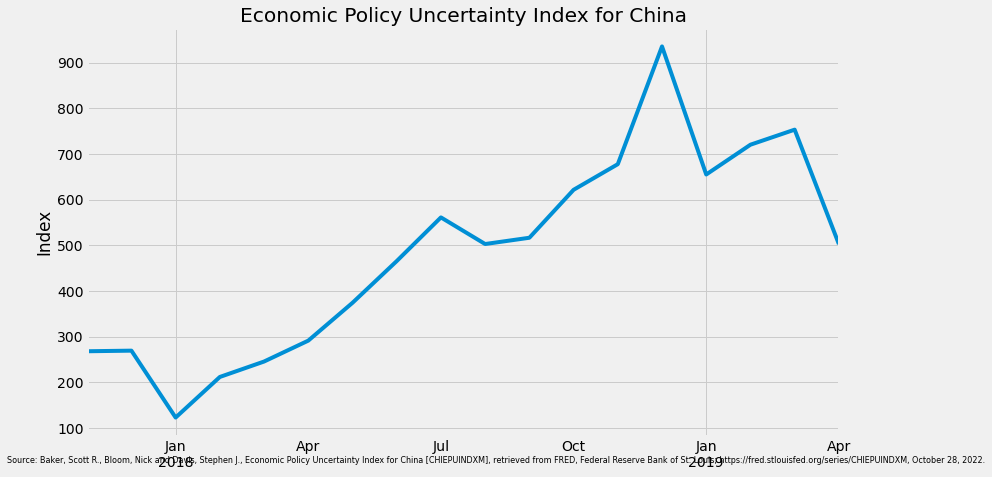

In [171]:
annotation = "Source: Baker, Scott R., Bloom, Nick and Davis, Stephen J., Economic Policy Uncertainty Index for China [CHIEPUINDXM], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CHIEPUINDXM, October 28, 2022."
plt_ch_econ = ch_econ_df.plot(
    figsize=(12, 7), 
    title="Economic Policy Uncertainty Index for China",
    ylabel="Index"
)
plt_ch_econ.annotate(annotation, (0,0), (-80,-20), fontsize=8, xycoords="axes fraction", textcoords="offset points", va="top")

### Equity market volatility - commodity markets

In [172]:
commodity_df = fred.get_series("EMVCOMMMKT", observation_start=start_date)
display(commodity_df.head())
display(commodity_df.tail())

2017-11-01     5.77657
2017-12-01     6.95476
2018-01-01     7.08699
2018-02-01    10.79867
2018-03-01     9.83779
dtype: float64

2022-04-01     8.56844
2022-05-01    13.17406
2022-06-01     7.02604
2022-07-01    10.19806
2022-08-01     6.08326
dtype: float64

In [173]:
commodity_df.isna().sum()

0

Text(-80, -20, 'Source: Baker, Scott R., Bloom, Nick and Davis, Stephen J., Equity Market Volatility Tracker: Commodity Markets [EMVCOMMMKT], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/EMVCOMMMKT, October 28, 2022.')

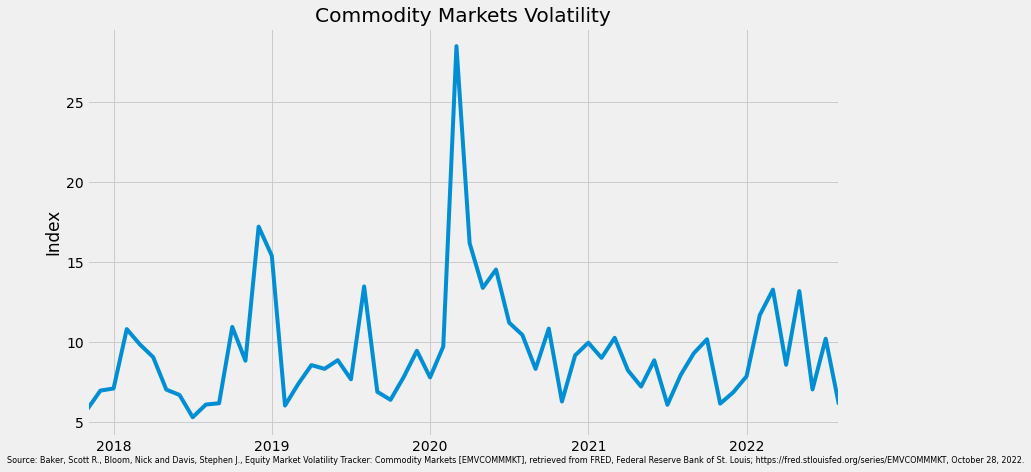

In [174]:
annotation = "Source: Baker, Scott R., Bloom, Nick and Davis, Stephen J., Equity Market Volatility Tracker: Commodity Markets [EMVCOMMMKT], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/EMVCOMMMKT, October 28, 2022."
plt_commodity = commodity_df.plot(
    figsize=(12, 7), 
    title="Commodity Markets Volatility",
    ylabel="Index"
)
plt_commodity.annotate(annotation, (0,0), (-80,-20), fontsize=8, xycoords="axes fraction", textcoords="offset points", va="top")

### Exchange rate market volatility

In [175]:
ex_rate_df = fred.get_series("EMVCOMMMKT", observation_start=start_date)
display(ex_rate_df.head())
display(ex_rate_df.tail())

2017-11-01     5.77657
2017-12-01     6.95476
2018-01-01     7.08699
2018-02-01    10.79867
2018-03-01     9.83779
dtype: float64

2022-04-01     8.56844
2022-05-01    13.17406
2022-06-01     7.02604
2022-07-01    10.19806
2022-08-01     6.08326
dtype: float64

In [176]:
ex_rate_df.isna().sum()

0

Text(-80, -20, 'Source: Baker, Scott R., Bloom, Nick and Davis, Stephen J., Equity Market Volatility Tracker: Exchange Rates [EMVEXRATES], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/EMVEXRATES, October 28, 2022.')

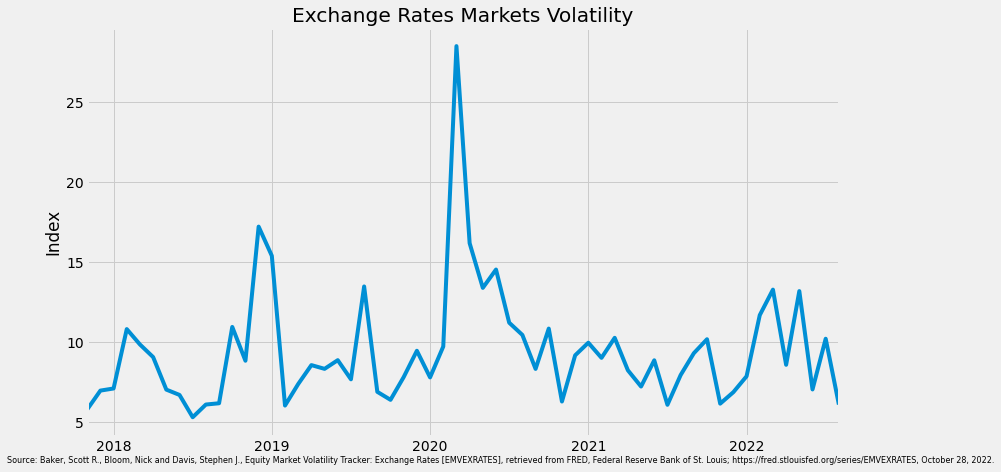

In [177]:
annotation = "Source: Baker, Scott R., Bloom, Nick and Davis, Stephen J., Equity Market Volatility Tracker: Exchange Rates [EMVEXRATES], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/EMVEXRATES, October 28, 2022."
plt_ex_rate = ex_rate_df.plot(
    figsize=(12, 7), 
    title="Exchange Rates Markets Volatility",
    ylabel="Index"
)
plt_ex_rate.annotate(annotation, (0,0), (-80,-20), fontsize=8, xycoords="axes fraction", textcoords="offset points", va="top")

### Twitter Economic Uncertainty Indices

In [178]:
teu_df = pd.read_excel(Path("../data/Twitter_Economic_Uncertainty.xlsx"),sheet_name="Sheet1", index_col="date")
display(teu_df.head())
display(teu_df.tail())

TEU-ENG     TEU-USA     TEU-WGT     TEU-SCA    TMU-ENG  \
date                                                                    
2011-06-01   34.977314   39.442967   30.348728  104.105534  41.814588   
2011-06-02   73.563817   91.005509   78.242405  201.509622  67.602878   
2011-06-03   43.898007   71.343746   58.318990  164.992417  47.130142   
2011-06-04   70.436015  129.990484  105.572418  321.743322  39.638914   
2011-06-05  114.788234  214.368848  176.405940  436.805026  32.931358   

              TMU-USA    TMU-WGT     TMU-SCA  
date                                          
2011-06-01  65.620824  57.704897  166.454924  
2011-06-02  63.121922  52.420494  132.309089  
2011-06-03  65.956686  56.699973  145.117299  
2011-06-04  27.340489  27.090964   65.024720  
2011-06-05  69.683066  61.266693  134.689575

TEU-ENG     TEU-USA     TEU-WGT     TEU-SCA     TMU-ENG  \
date                                                                     
2022-10-24  341.058869  245.751376  230.152949   91.767354  313.644746   
2022-10-25  269.802482  203.800805  179.815161   79.138203  195.861804   
2022-10-26  262.329853  218.251084  209.699863   78.827980  216.539830   
2022-10-27  265.695197  243.573568  244.737242  101.859799  199.735777   
2022-10-28  207.239430  176.808413  158.208954   70.531875  169.487240   

               TMU-USA     TMU-WGT    TMU-SCA  
date                                           
2022-10-24  168.585206  170.866628  59.821855  
2022-10-25  152.088894  168.544052  56.482692  
2022-10-26  128.717771  129.301788  44.680006  
2022-10-27  143.917983  142.561844  56.972998  
2022-10-28  137.648736  138.033859  52.240463

In [179]:
# Choose English -language tweets
teu_eng = teu_df.loc[pd.to_datetime("2018-01-01"):, "TEU-SCA"]
teu_eng

date
2018-01-01     14.958242
2018-01-02     56.565298
2018-01-03     56.390498
2018-01-04     49.827318
2018-01-05     26.785765
                 ...    
2022-10-24     91.767354
2022-10-25     79.138203
2022-10-26     78.827980
2022-10-27    101.859799
2022-10-28     70.531875
Name: TEU-SCA, Length: 1762, dtype: float64

Text(-80, -20, 'Source: Renault, Thomas, Baker, Scott R., Bloom, Nick and Davis, Stephen J., Twitter-based Uncertainty Indices, retrieved from Economic Policy Uncertainty; http://www.policyuncertainty.com/twitter_uncert.html, October 28, 2022.')

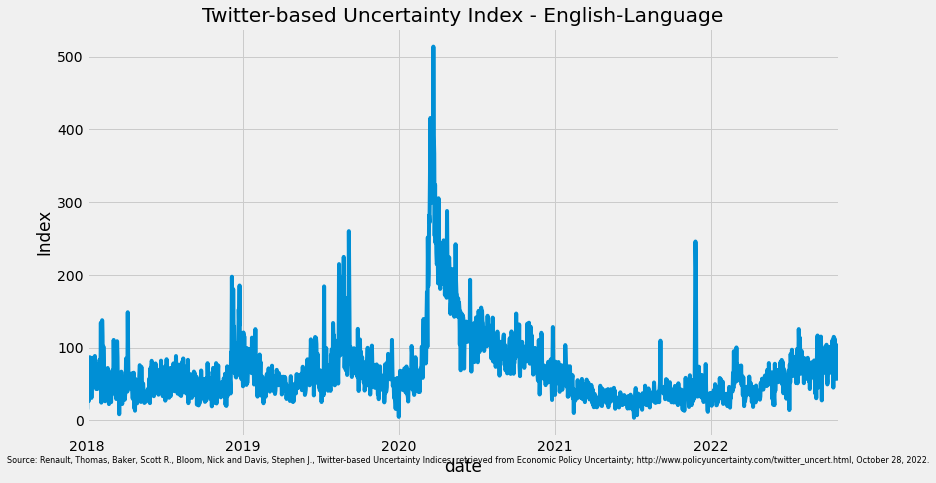

In [180]:
annotation = "Source: Renault, Thomas, Baker, Scott R., Bloom, Nick and Davis, Stephen J., Twitter-based Uncertainty Indices, retrieved from Economic Policy Uncertainty; http://www.policyuncertainty.com/twitter_uncert.html, October 28, 2022."
plt_teu = teu_eng.plot(
    figsize=(12, 7), 
    title="Twitter-based Uncertainty Index - English-Language",
    ylabel="Index"
)
plt_teu.annotate(annotation, (0,0), (-80,-20), fontsize=8, xycoords="axes fraction", textcoords="offset points", va="top")

### All infectious disease equity markets volatility index

In [181]:
all_diseases_df = pd.read_csv(
    Path("../data/All_Infectious_EMV_Data.csv"), 
    parse_dates={"date" : ["year", "month", "day"]},
    index_col="date"
)
display(all_diseases_df.head())
display(all_diseases_df.tail())

daily_infect_emv_index
date                              
1985-01-01                     0.0
1985-01-02                     0.0
1985-01-03                     0.0
1985-01-04                     0.0
1985-01-05                     0.0

daily_infect_emv_index
date                              
2022-10-24                    8.56
2022-10-25                   14.16
2022-10-26                   14.04
2022-10-27                   10.99
2022-10-28                    8.24

We are only interested in disease data from 2018 to today

In [182]:
dis_df = all_diseases_df.loc[start_date:]
dis_df

daily_infect_emv_index
date                              
2017-11-09                    0.00
2017-11-10                    0.00
2017-11-11                    0.00
2017-11-12                    0.50
2017-11-13                    0.00
...                            ...
2022-10-24                    8.56
2022-10-25                   14.16
2022-10-26                   14.04
2022-10-27                   10.99
2022-10-28                    8.24

[1815 rows x 1 columns]

Text(-80, -20, 'Source: Baker, Scott R., Bloom, Nick and Davis, Stephen J., Kost, Kyle, Sammon, Marco, Viratyosin, Tasaneeya, Daily Infectious Disease Equity Market Volatility Tracker, retrieved from Economic Policy Uncertainty; http://www.policyuncertainty.com/twitter_uncert.html, October 28, 2022.')

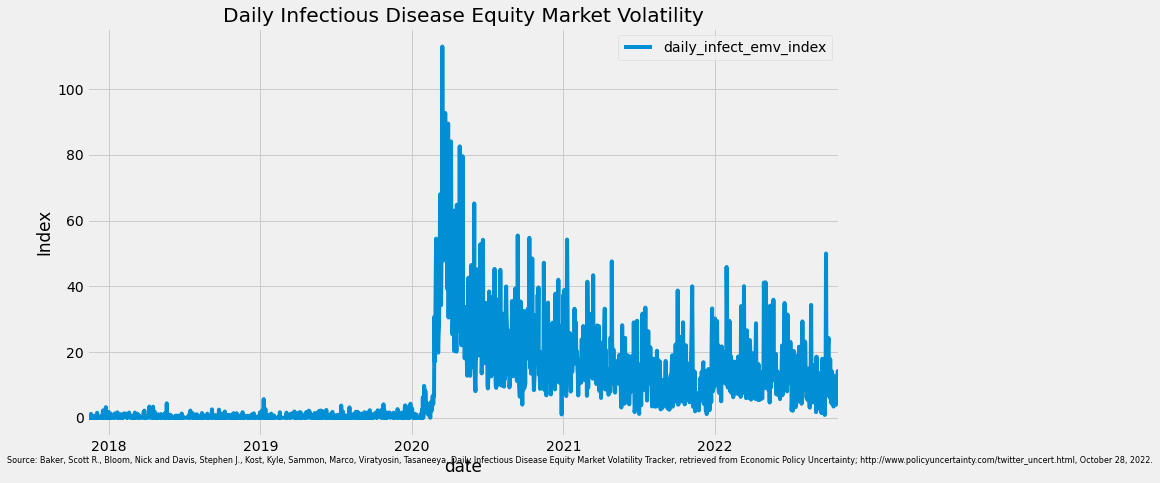

In [183]:
annotation = "Source: Baker, Scott R., Bloom, Nick and Davis, Stephen J., Kost, Kyle, Sammon, Marco, Viratyosin, Tasaneeya, Daily Infectious Disease Equity Market Volatility Tracker, retrieved from Economic Policy Uncertainty; http://www.policyuncertainty.com/twitter_uncert.html, October 28, 2022."
plt_dis = dis_df.plot(
    figsize=(12, 7), 
    title="Daily Infectious Disease Equity Market Volatility",
    ylabel="Index"
)
plt_dis.annotate(annotation, (0,0), (-80,-20), fontsize=8, xycoords="axes fraction", textcoords="offset points", va="top")